# Visualizing Simulation Results
### Authors:
##### Justin Tung:      'https://github.com/JayTongue'
##### Matt Adam-Houser: 'https://github.com/mhouser42'

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
import pickle
import networkx as nx
import ipywidgets
from ipywidgets import widgets
from IPython.display import Image 

from run_simulation import saturation_main  # Custom function from run_simulation.py
from visualization_functions import *

---------------------------------
----------------------------------
# 1. Running and Visualizing One Simulation

Sample output from one simulation of the saturation code:

saturation_main() takes two arguments:

`run_mode` types are "Poison ToH", "Population-Based Countermeasures", "Quarantine", or "All"

`years_run` is the number of years for which you want to run the simulation for

This notebook and these files are largely designed to run without additional user input.


In [2]:
years_run = 15
run_mode = 'Baseline'
life_cycle = False
simulation_df = saturation_main(run_mode, years_run, life_cycle=life_cycle)  # Don't use variables as defaults!!!
simulation_df

,County,year 0,year 1,year 2,year 3,year 4,year 5,year 6,year 7,year 8,year 9,year 10,year 11,year 12,year 13,year 14,year 15
0,Cook,0.3,0.320931,0.263942,0.478708,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.0,1.00000,1.000000
1,DuPage,0.0,0.104436,0.260339,0.621424,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.0,1.00000,1.000000
2,Kane,0.0,0.109284,0.098412,0.486803,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.0,1.00000,1.000000
3,Will,0.0,0.152737,0.313779,0.789038,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.0,1.00000,1.000000
4,Winnebago,0.0,0.000000,0.010442,0.013007,0.099848,0.248057,0.325289,0.639822,1.0,1.000000,0.805314,1.000000,1.0,1.0,0.73709,0.678600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,Henderson,0.0,0.000000,0.000000,0.067978,0.214571,0.261667,0.026821,0.282073,1.0,1.000000,1.000000,0.745468,1.0,1.0,1.00000,1.000000
98,Calhoun,0.0,0.017664,0.000000,0.000000,0.071500,0.110484,0.209600,0.826322,1.0,0.998167,1.000000,1.000000,1.0,1.0,1.00000,1.000000
99,Schuyler,0.0,0.002585,0.012063,0.059972,0.121115,0.160242,0.389610,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.0,1.00000,1.000000
100,Gallatin,0.0,0.003055,0.152728,0.841971,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.0,1.00000,0.163787


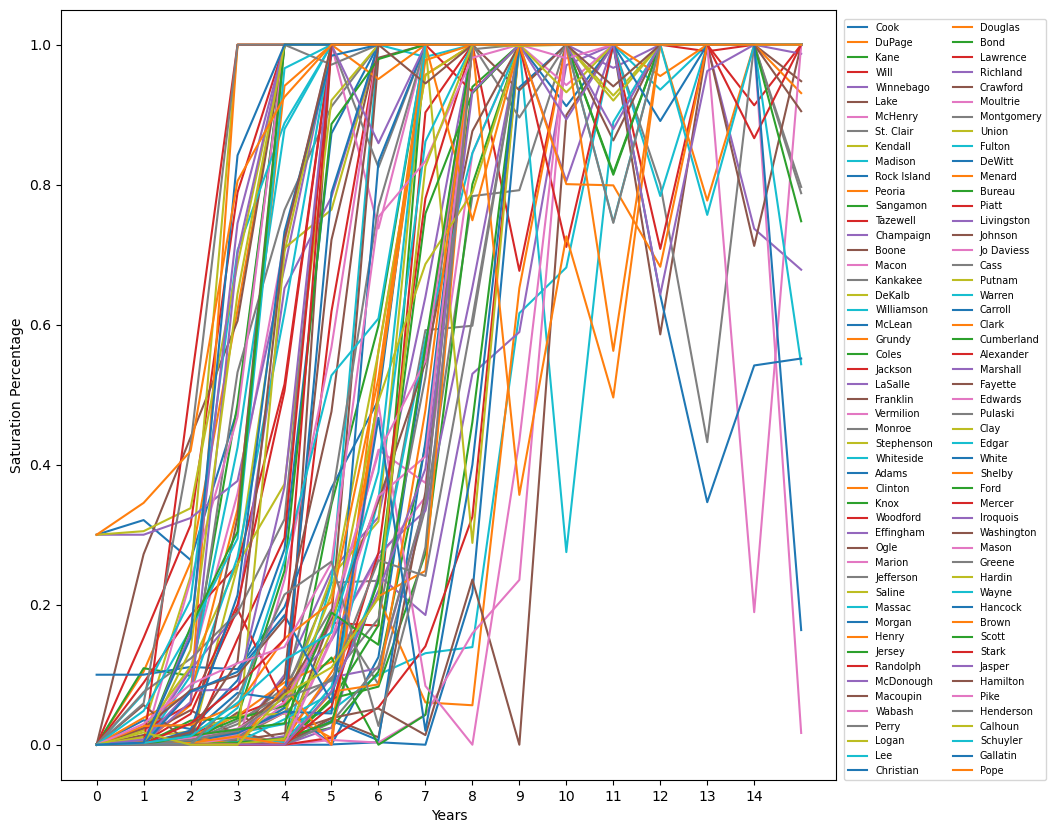

In [3]:
visual_df = make_visual_df(simulation_df)

# Make plots for each county
plt.figure(figsize=(10,10))
for county in visual_df.columns:
    plt.plot(visual_df.index, visual_df[county])
plt.xticks(ticks=range(0, years_run),
    labels=range(0, years_run))
plt.xlabel('Years')
plt.ylabel('Saturation Percentage')
plt.legend(visual_df.columns, loc=(1.01, 0), fontsize=7, ncol=2)
plt.show()

While this graph can display the lanternfly life-cyclem, where adults die in the winter and eggs hatch in the spring, the graph is otherwise is not very helpful. Since there are 102 Counties in Illinois, the resulting graph is messy and visually confusing. 

An alternative way of visualizing this data may be with a sort of heatmap instead

In [4]:
path = 'data/location'
edges = pd.read_csv(f'{path}/county_edges.csv')

CG = pickle.load(open(f'{path}/IL_graph.dat', 'rb'))
handler = pickle.load(open(f'{path}/graph_handler_counties.dat', 'rb'))
highways = pickle.load(open(f'{path}/osmnx_highways.dat', 'rb'))

In [5]:
widgets.interact(make_network_heat,
                 CG=widgets.fixed(CG),
                 handler=widgets.fixed(handler),
                 simulation_df=widgets.fixed(simulation_df),
                 iteration=widgets.IntSlider(min=0, max=years_run - 1, step=1, layout=widgets.Layout(width='800px')),
                 time_frame='year'
)

interactive(children=(IntSlider(value=0, description='iteration', layout=Layout(width='800px'), max=14), Text(…

<function visualization_functions.make_network_heat(CG: networkx.classes.graph.Graph, simulation_df: pandas.core.frame.DataFrame, handler: dict, iteration: int, time_frame=None)>

In order to better see the flow of saturations from week to week, we animated the slider:

In [6]:
play = widgets.interact(make_network_heat,
                        CG=widgets.fixed(CG),
                        handler=widgets.fixed(handler),
                        time_frame = 'year',
                        simulation_df=widgets.fixed(simulation_df),iteration=widgets.Play(value=0,
                                                                                      min=0,
                                                                                      max=years_run - 1,
                                                                                      step=1,
                                                                                      interval=750,
                                                                                      disabled=False,
                                                                                     ))

interactive(children=(Play(value=0, description='iteration', interval=750, max=14), Text(value='year', descrip…

Showing the saturation of the state as a whole is more helpful than each individual county:

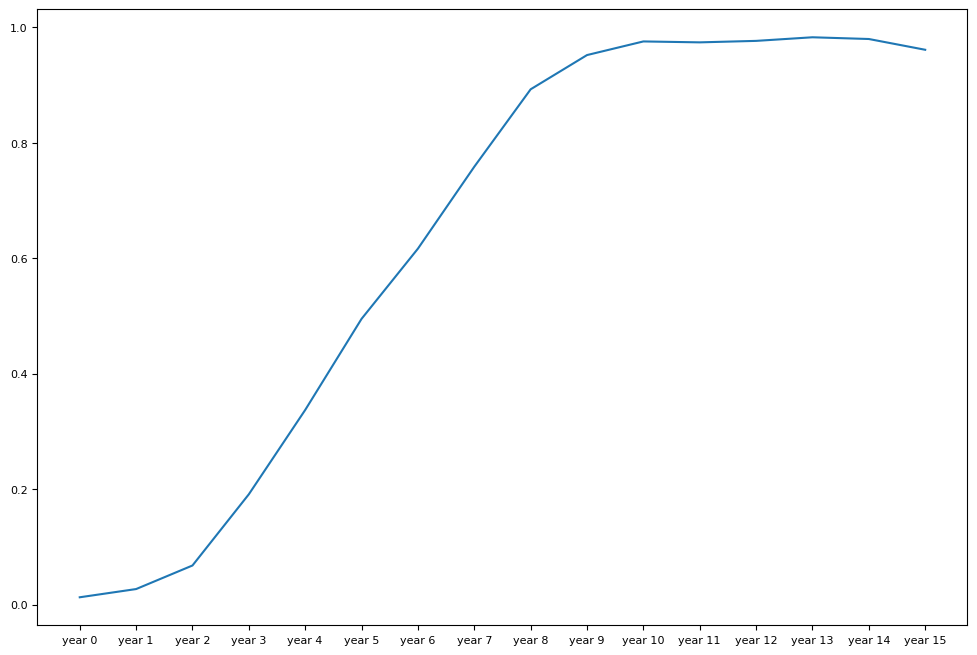

In [7]:
avg_df = visual_df.mean(axis=1)
plt.figure(figsize=(12,8))
plt.plot(avg_df.index, avg_df.iloc[0:, ])
plt.tick_params(labelsize=8)

In [8]:
Image(url='references/standard_curve.jpg', width=800)

Note that due to the nature of Monte Carlo stochasticity, every time the simulation is run, the curve will change. 

--------------------------------
# 2. Running the Simulation as a Monte Carlo and Plotting the Results

With this line graph, we can run the simulation as many times as desired and compare the results.

This interactive graph shows different run modes, different experiment durations, and different numbers of simulations.

In [9]:
widgets.interact(model_variables,
    run_mode =['Baseline', 'Poison ToH', 'Population-Based Countermeasures', 'Quarantine', 'All'],
    sims_run = (10, 100, 10),
    sim_iterations = (1, 60, 1),
    value='Baseline',
    prefix='',
    time_frame='year',
    disabled=False,

)

interactive(children=(Dropdown(description='run_mode', options=('Baseline', 'Poison ToH', 'Population-Based Co…

<function visualization_functions.model_variables(run_mode: str, sims_run: int, sim_iterations: int, life_cycle=False, prefix=None)>

------------------------------------------------
# 3. Model the Impact of a Experimental Variable Manipulation

After running multiple simulations on each model, the resulting average trend lines can be determined for each experimental varaible.

Note that these simulations are extended to 30 years to show longer-term trends.

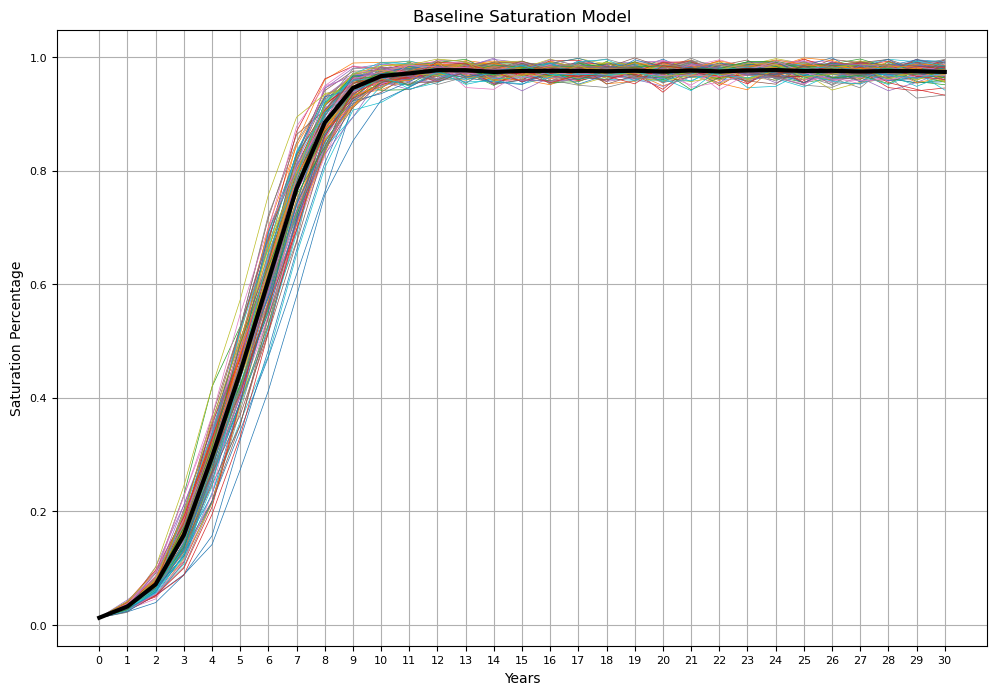

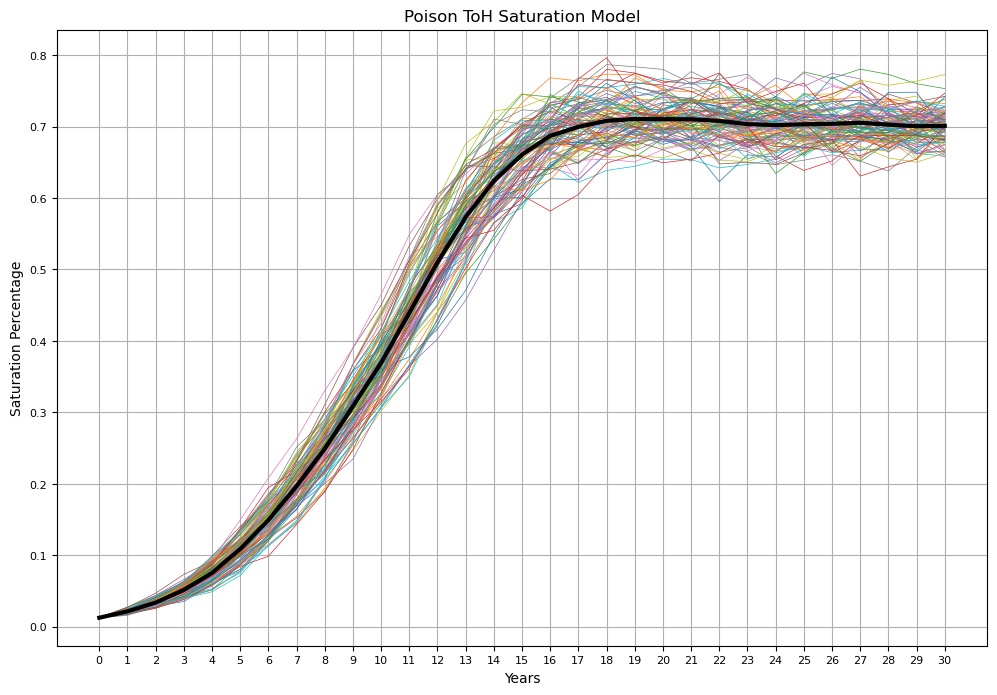

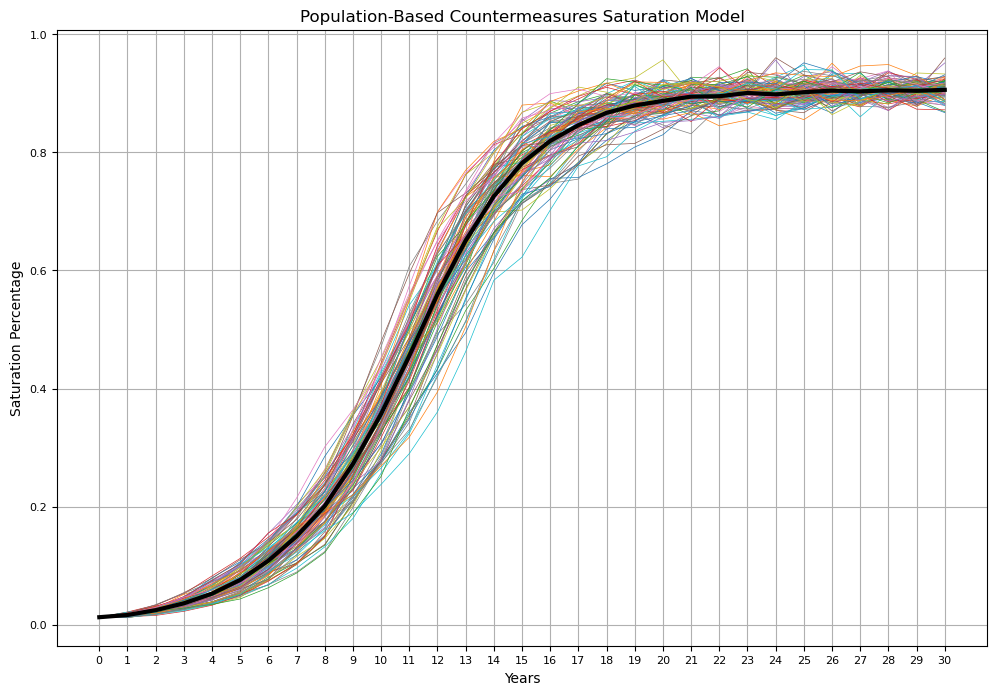

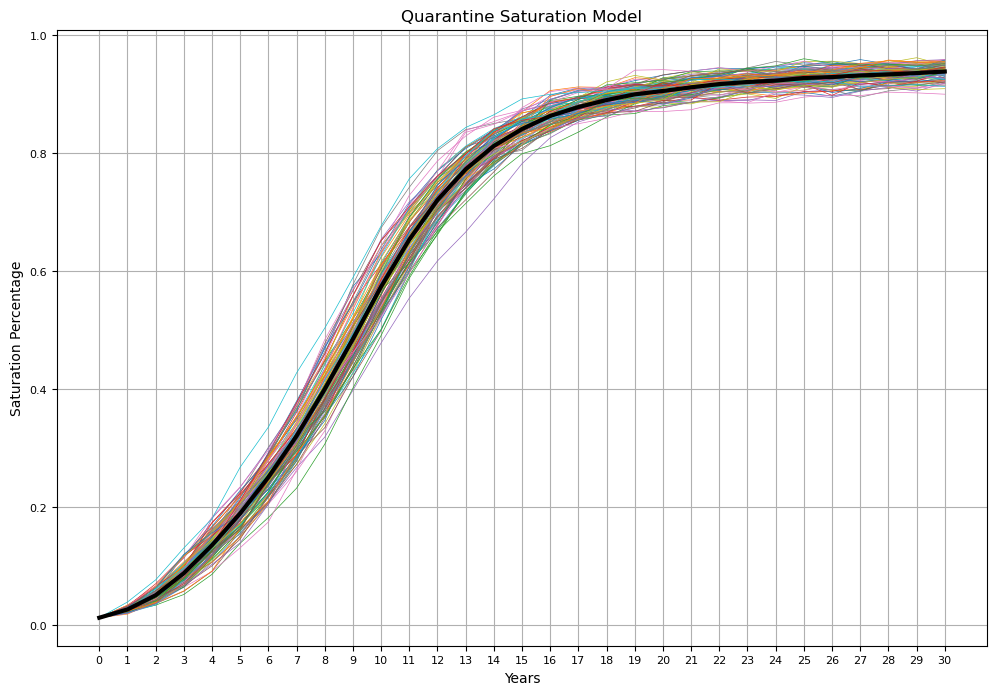

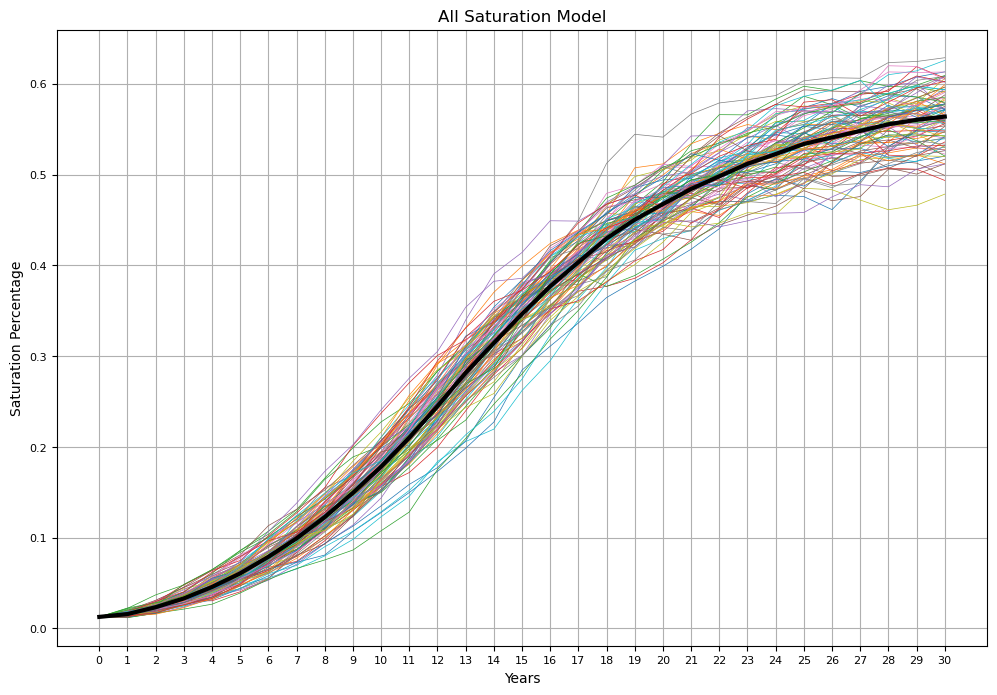

In [10]:
sims_run = 100
sim_years = 30

all_trends = {}
for mode in ['Baseline', 'Poison ToH', 'Population-Based Countermeasures', 'Quarantine', 'All']:
    all_trends = model_variables_avg(mode, sims_run, sim_years, all_trends)

-----------------------------------------------
# 4. Compare Average Trend Lines to Determine Efficacy of Interventions

By comparing the derived trend lines, the effect of each proposed intervention can be compared.

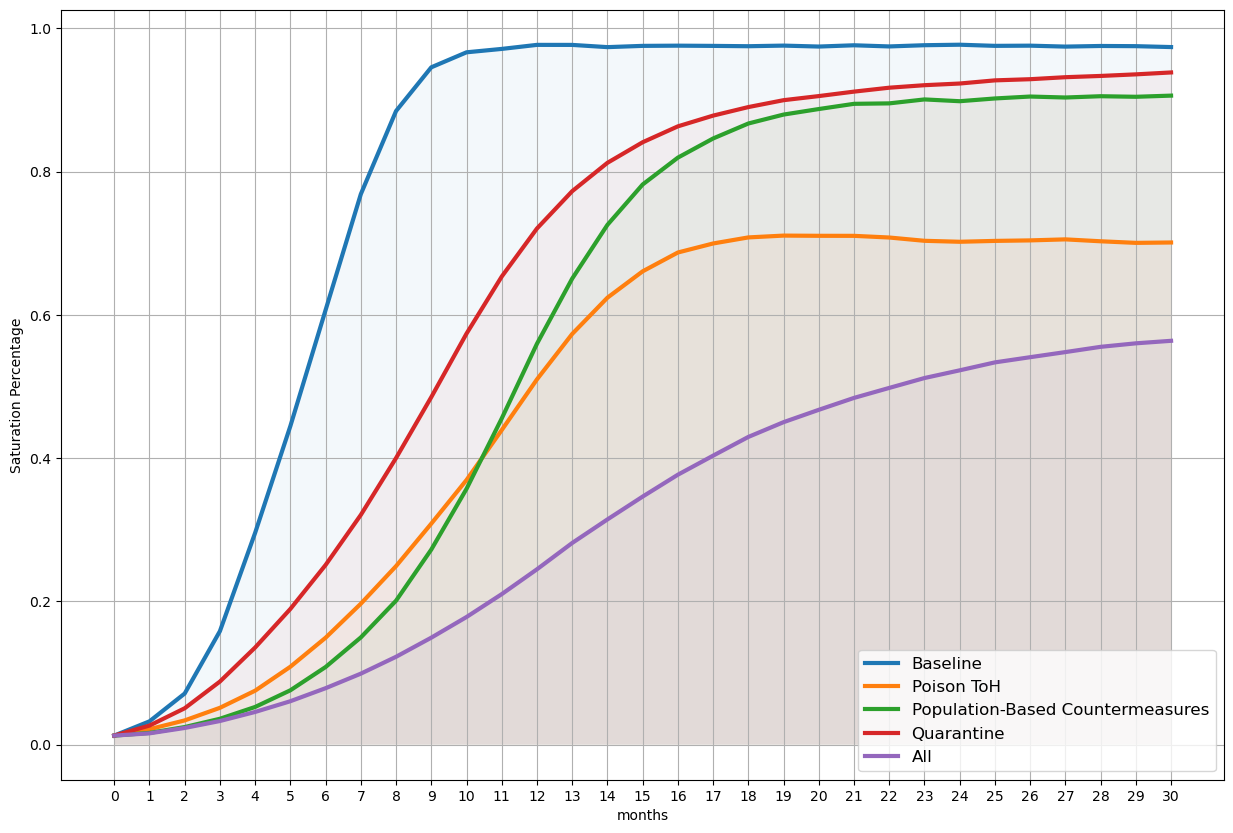

In [11]:
fig, ax = plt.subplots(figsize=(15, 10))

plt.xticks(ticks=range(0, sim_years+1),
            labels=range(0, sim_years+1))
plt.xlabel('months')
plt.ylabel('Saturation Percentage')

for model in all_trends:
    trend_sr = all_trends[model]
    X = trend_sr.index.tolist()
    Y = trend_sr.values.tolist()
    
    ax.plot(X, Y, label=model, linewidth=3)
    ax.fill_between(X, Y, 0, alpha=0.05, interpolate=True)

plt.grid()
plt.legend(fontsize=12)
plt.show()